# **Deep Learning based Bean Leaf Lesions Classification**

## **Project Overview:**
Welcome to our Deep Learning project on classifying bean leaf lesions. In this project, we'll be using deep learning to classify different types of conditions affecting bean leaves. The goal is to teach a computer model to look at images of bean leaves and tell whether they are healthy or suffering from one of two diseases: angular leaf spot or bean rust. Agriculture plays a crucial role in our world, and healthy crops are essential for food production. Beans are a significant crop globally, but they can be affected by various diseases. Quick and accurate identification of these diseases can help farmers manage their crops more effectively, leading to better yield and less waste. This is where our project comes in, using technology to assist in early disease detection.

## **The Dataset:**
We're using Bean Leaf Lesions Classification Datasetfrom Kaggle, which can be found [here](https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification/data). This dataset contains photographs of bean leaves in three different states including (i) healthy, (ii) with angular leaf spot, and (iii) with bean rust. It includes 1,034 images for training our model and 133 images for testing its accuracy. The dataset is a perfect starting point for anyone interested in applying image classification techniques in agriculture.

## **What We'll Do:**

**1. Data Preparation:** We'll start by loading and preparing our data, making it ready for the model to learn from.

**2. Model Building:** Next, we'll build a neural network, a type of model that's especially good at learning from images.

**3. Model Training and Validation:** We'll then train our model on the training data and validate its performance using the validation data.

**4. Model Evaluation:** After training, we'll evaluate our model's accuracy and ability to correctly classify the bean leaf images on the test set.

**5. Results and Visualization:** Finally, we'll visualize the results to understand our model's performance better and draw meaningful conclusions.

## **Who Is This For?**
Whether you're a complete beginner in machine learning or have some experience, we've structured this notebook to be clear, informative, and engaging. We'll walk through each step of the process, explaining the concepts and code in a way that's accessible to all.

So let's dive in and explore the fascinating world of deep learning and agriculture!

# **Step 1: Data Preparation**
This part will include importing libraries, creating dataframes for training and validation datasets, and setting up data transformations. It will cover the initial block of code for importing libraries and the sections where the "train_df" and "val_df" dataframes are created and processed. The data transformations (train_transforms and test_transforms) will also be included here.

In [1]:
# Mount Google Drive with Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.1 Import Libraries**
We begin by importing necessary Python libraries. These libraries help us with data manipulation (pandas, numpy), handling images (PIL, matplotlib), and more.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob

### **1.2 Load and Organize the Data**
We need to load the images and their corresponding labels. The data consists of images in different folders, each representing a class (healthy, angular_leaf_spot, bean_rust).

In [3]:
# Create dataframes to hold paths and labels
train_df = pd.DataFrame({"path":[], "label":[], "class_id":[]})
val_df = pd.DataFrame({"path":[], "label":[], "class_id":[]})

In [4]:
# Define the path to the training and validation data
train_path = '/content/drive/MyDrive/Bean-Leaf-Lesions-Classification/INPUT_DATASET/train'
val_path = '/content/drive/MyDrive/Bean-Leaf-Lesions-Classification/INPUT_DATASET/val'

In [5]:
# Define a dictionary to map labels to numeric ids
label_dict = {"healthy": 0, "angular_leaf_spot": 1, "bean_rust": 2}

In [6]:
# Function to load images and labels into the dataframe
def load_images(path, label_dict):
    df = pd.DataFrame({"path":[], "label":[], "class_id":[]})
    folder_list = os.listdir(path)
    for folder in folder_list:
        img_path = os.path.join(path, folder)
        jpg_list = glob(img_path + '/*.jpg')
        for jpg in jpg_list:
            new_data = pd.DataFrame({"path": [jpg], "label": [folder], "class_id": [label_dict[folder]]})
            df = pd.concat([df, new_data], ignore_index=True)
    return df

In [7]:
# Load training and validation data
train_df = load_images(train_path, label_dict)
val_df = load_images(val_path, label_dict)

### **1.3 Data Visualization**
It's often useful to visualize some of the data. Here, we'll randomly select and display a few images from the training set.

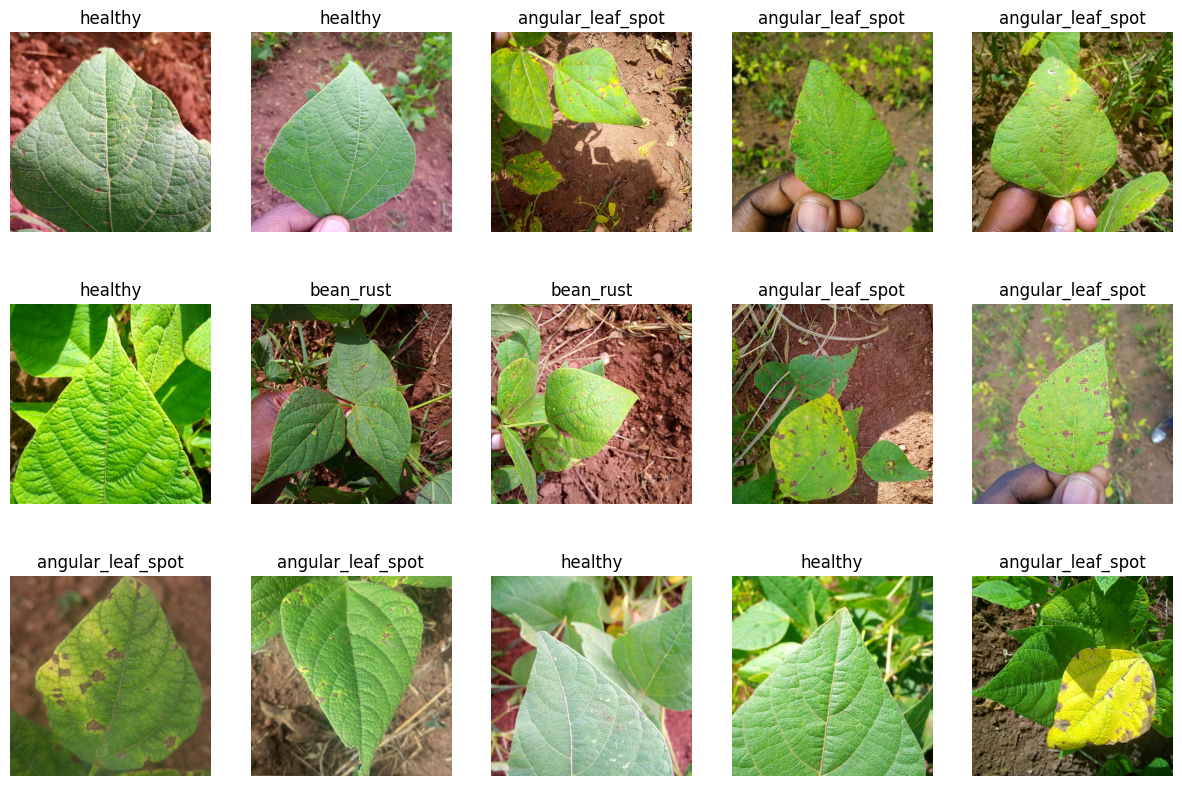

In [8]:
show_imgs = 15
idx = np.random.randint(0, len(train_df), size=show_imgs)
fig, axes = plt.subplots(show_imgs // 5, 5, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

plt.show()

### **1.4 Data Transformation and Augmentation**
We'll use PyTorch's transforms for preprocessing and augmenting the images. This step is crucial for deep learning models to generalize better.

In [9]:
# Data Transformation and Augmentation
import torchvision.transforms as transforms

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # Other transformations can be added here
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### **1.5 Create Custom Dataset**
We create a custom dataset class that extends PyTorch's Dataset. This class will handle loading images and applying the transformations.

In [10]:
# Create Custom Dataset
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        img = Image.open(image_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

### **1.6 Create DataLoaders**
Finally, we set up PyTorch DataLoaders for both the training and validation datasets. DataLoaders allow efficient loading and batching of data during training.

In [11]:
# Create DataLoaders
from torch.utils.data import DataLoader

train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, val_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

This completes the Data Preparation step. Next, we'll move on to building the model.

# **Step 2: Model Building**
In this section, we"ll focus on setting up the deep learning model. It will cover the part of the script where the neural network model is loaded (using PyTorch's pre-trained models) and modified for the specific classification task. This includes the creation of the MyDataset class and the modification of the model's classifier layer.

### **2.1 Import Necessary Libraries**
First, we need to import the necessary components from PyTorch.

In [12]:
import torch
import torch.nn as nn
from torchvision import models

### **2.2 Define the Model**
We will use a pre-trained model and modify its final layer to suit our classification task, which has three classes (healthy, angular_leaf_spot, bean_rust).

In [13]:
# Define the number of classes
num_classes = 3

# Load a pre-trained model
model = models.efficientnet_v2_s(pretrained=True)

# Modify the classifier
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Print the Deep Learning model architecture
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:02<00:00, 37.7MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### **2.3 Set the Device**
We need to set the device to either CPU or GPU (if available) for training.

In [14]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = model.to(device)

### **2.4 Print Model Summary**

In [15]:
!pip install torchsummary

In [16]:
from torchsummary import summary

# Print the model summary (for input size [3, 224, 224])
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

This completes the model building step. We have successfully loaded a pre-trained EfficientNet model and adapted it for our three-class classification task. The model is now ready to be trained on our bean leaf lesions dataset.

# **Step 3: Model Training and Validation**
This part will encompass the training loop and the functions needed for training (train) and validation (test). It will detail the steps of the training process, including setting up the loss function, optimizer, learning rate scheduler, and the training loop itself, which includes early stopping.

### **3.1 Import Necessary Libraries**
First, we need to ensure that all necessary libraries are imported.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

### **3.2 Define Loss Function, Optimizer, and Learning Rate Scheduler**
Before training, we define the loss function, the optimizer, and the learning rate scheduler.

In [18]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (using AdamW here)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Learning rate scheduler (optional)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### **3.3 Training and Validation Functions**
Define the functions for training and validating the model.

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the metrics as Python numbers
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())  # Convert to Python number
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())  # Convert to Python number

    print('Training complete')

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

### **3.4 Train the Model**
Now, we use the defined functions to train and validate our model. Set the number of epochs as per your requirement.



In [20]:
model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.7724 Acc: 0.7031
val Loss: 0.3134 Acc: 0.9398
Epoch 2/25
----------
train Loss: 0.2669 Acc: 0.9130
val Loss: 0.1252 Acc: 0.9774
Epoch 3/25
----------
train Loss: 0.1986 Acc: 0.9294
val Loss: 0.1224 Acc: 0.9699
Epoch 4/25
----------
train Loss: 0.1482 Acc: 0.9468
val Loss: 0.0865 Acc: 0.9699
Epoch 5/25
----------
train Loss: 0.1058 Acc: 0.9691
val Loss: 0.1048 Acc: 0.9774
Epoch 6/25
----------
train Loss: 0.1106 Acc: 0.9613
val Loss: 0.0701 Acc: 0.9774
Epoch 7/25
----------
train Loss: 0.1228 Acc: 0.9555
val Loss: 0.0834 Acc: 0.9699
Epoch 8/25
----------
train Loss: 0.0925 Acc: 0.9662
val Loss: 0.0650 Acc: 0.9699
Epoch 9/25
----------
train Loss: 0.0701 Acc: 0.9797
val Loss: 0.0714 Acc: 0.9699
Epoch 10/25
----------
train Loss: 0.1006 Acc: 0.9700
val Loss: 0.0679 Acc: 0.9699
Epoch 11/25
----------
train Loss: 0.0854 Acc: 0.9662
val Loss: 0.0715 Acc: 0.9699
Epoch 12/25
----------
train Loss: 0.0730 Acc: 0.9768
val Loss: 0.0640 Acc: 0.9699
Epoch 13/25
-

In [21]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Bean-Leaf-Lesions-Classification/TRAINED_MODEL/bean_leaf_model_3.pth')

### **3.5 Plotting the Metrics**
After training, we will use matplotlib to plot the loss and accuracy during model training in a graph.

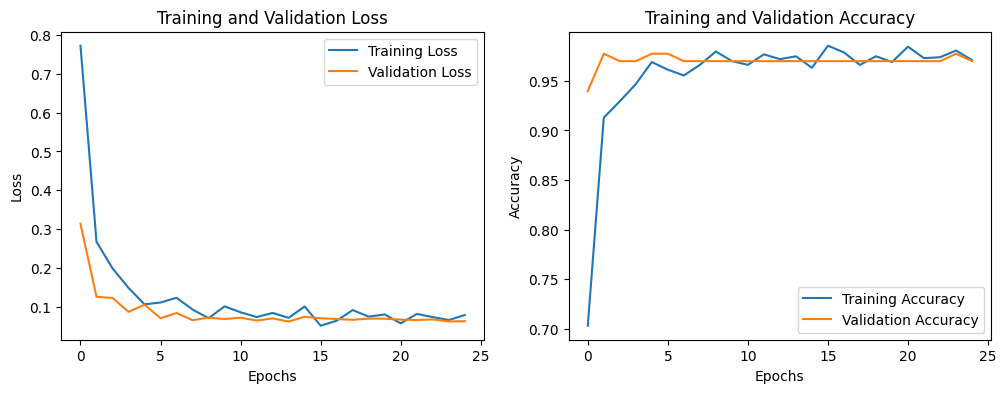

In [22]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

This concludes the Model Training and Validation step. In this phase, we trained our model on the training dataset and evaluated its performance on the validation dataset. The model's weights are updated to learn from the training data, and its accuracy and loss are monitored to ensure proper learning. Next, in Step 4, we will evaluate our trained model's performance in more detail, particularly on the validation set.

# **Step 4: Model Evaluation**
Here, we"ll focus on loading the best model and evaluating its performance on the validation dataset. This part will cover the script sections where the model is loaded from the saved state (best.pth), and the model's performance is evaluated using the validation dataset.

### **4.1 Evaluate the Model**
First, we'll create a function to evaluate the model. This function will use the validation dataset to predict labels and then compare them with the true labels.

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track the gradients
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate the model
all_labels, all_preds = evaluate_model(model, val_loader)

### **4.2 Classification Report and Accuracy**
We'll generate a classification report and calculate the accuracy.

In [24]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["healthy", "angular_leaf_spot", "bean_rust"]))

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Classification Report:
                   precision    recall  f1-score   support

          healthy       0.98      1.00      0.99        44
angular_leaf_spot       1.00      0.93      0.96        44
        bean_rust       0.94      0.98      0.96        45

         accuracy                           0.97       133
        macro avg       0.97      0.97      0.97       133
     weighted avg       0.97      0.97      0.97       133

Accuracy: 96.99%


This step provides a detailed view of how well your model performs on the validation set, highlighting its strengths and areas where it may need improvement. The classification report gives a comprehensive overview of the model's precision, recall, and F1-score for each class, while the confusion matrix visually represents the model's predictions against the actual labels.

### **4.33 Confusion Matrix**
Visualize the performance with a confusion matrix.

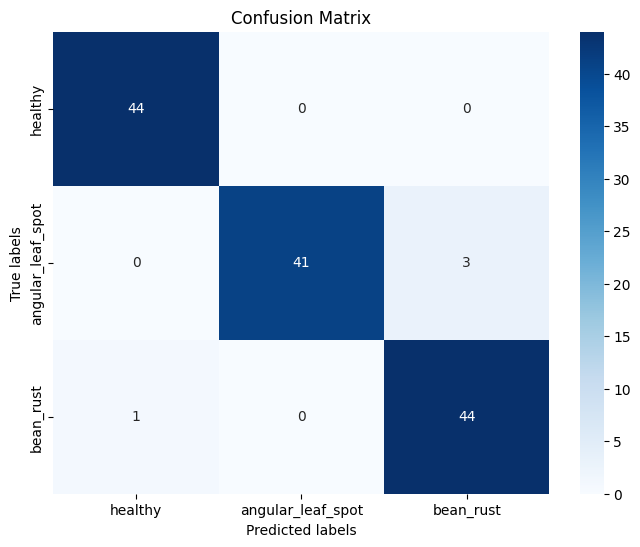

In [25]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["healthy", "angular_leaf_spot", "bean_rust"], yticklabels=["healthy", "angular_leaf_spot", "bean_rust"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

This concludes Step 4, Model Evaluation, where we assessed the performance of our trained deep learning model. By leveraging metrics like the classification report, accuracy, and the confusion matrix, we gained valuable insights into how well the model predicts each class and where it might be making mistakes.

Now, we move on to the final step, Step 5: "Results and Visualization." In this step, we will focus on visualizing the results from our model's training and evaluation process. This includes plotting the training and validation loss and accuracy curves over epochs, as well as visualizing any additional insights we might have gained from the model's performance on the validation set. This step is crucial for understanding the overall effectiveness of the model and for communicating the results in an easily interpretable manner.

# **Step 5: Results and Visualization**
Finally, this part will deal with visualizing the training results and the model's performance. It includes plotting the training and validation losses and accuracies, showing the confusion matrix, and printing the classification report.

### **5.1 Showcasing a Correct Prediction**
Next, let's visualize one instance from the validation dataset where our model has predicted correctly. We'll display the image, the true label, and the predicted label.

In [44]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_multiple_predictions(dataloader, model, device, num_images=15):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))  # Increased figure size for better spacing

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.shape[0]):
                if images_shown == num_images:
                    break

                confidence = torch.max(probabilities[i]).item() * 100  # Convert to percentage
                img = inputs[i].cpu().data.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                ax = plt.subplot(num_images // 5, 5, images_shown + 1)
                ax.imshow(img)
                ax.set_title(f'Prediction: {preds[i].item()}, Ground Truth: {labels[i].item()}\nConfidence: {confidence:.2f}%', fontsize=10)
                ax.axis('off')

                images_shown += 1

            if images_shown == num_images:
                break

    plt.subplots_adjust(hspace=0.03)  # Adjust horizontal space
    plt.show()

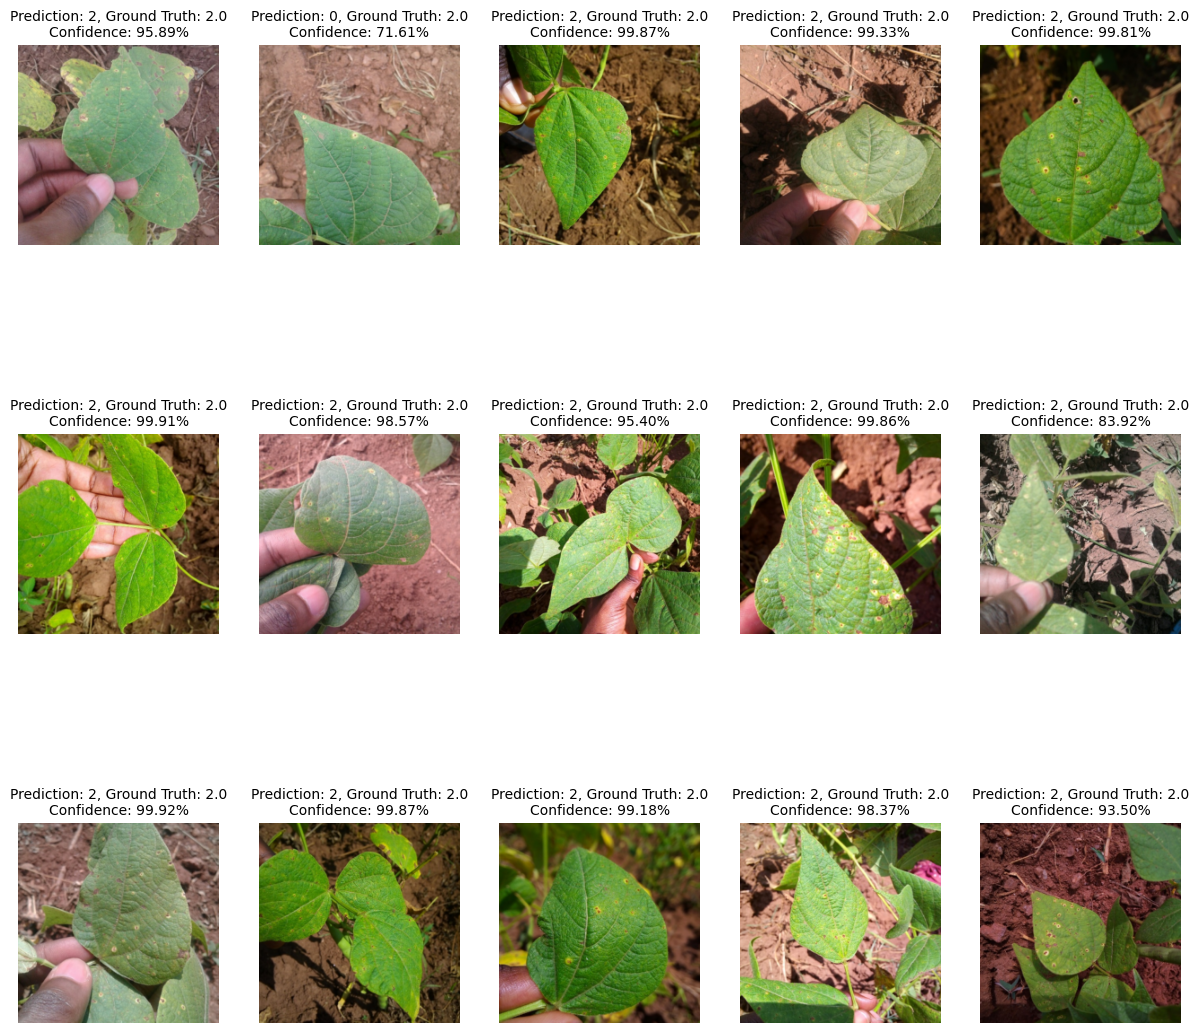

In [45]:
# Call the function to visualize predictions
visualize_multiple_predictions(val_loader, model, device, num_images=15)

# **Conclusion**
We've successfully completed our Bean Leaf Lesions Classification project. This journey took us through preparing our dataset, building and fine-tuning a deep learning model, and evaluating its performance. The visualizations provided clear insights into the model's accuracy and capabilities. This project not only enhanced our understanding of machine learning in practical applications but also demonstrated the impactful role it can play in agricultural health monitoring.

#**The End**